In [1]:
!pip install lime

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular

In [3]:
# Load dataset (update path if needed)
data = pd.read_csv('bank-additional-full.csv', sep=';')
# Show first 5 rows
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Dataset info and target distribution
print(data.info())
print(data['y'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# Encode target variable: 'yes' -> 1, 'no' -> 0
data['y'] = data['y'].map({'yes':1, 'no':0})
# Separate features and target
X = data.drop('y', axis=1)
y = data['y']
# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [6]:
# Preprocessing pipeline: OneHotEncode categorical features, pass through numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)
# Split data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
# Train models
logreg_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

C:\Users\bless\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\bless\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [8]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:\n{cm}")
    
    f1 = f1_score(y_test, y_pred)
    print(f"{model_name} F1 Score: {f1:.4f}")
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"{model_name} ROC AUC: {roc_auc:.4f}")
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

Logistic Regression Confusion Matrix:
[[7147  163]
 [ 528  400]]
Logistic Regression F1 Score: 0.5366
Logistic Regression ROC AUC: 0.9391


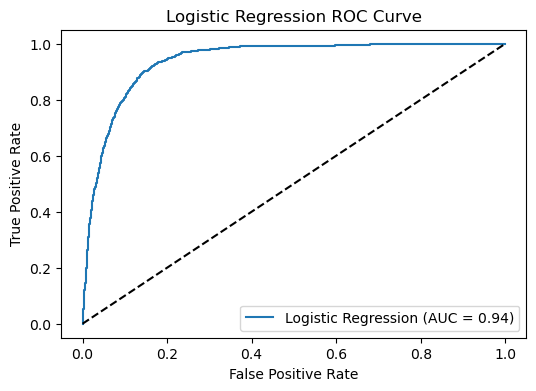

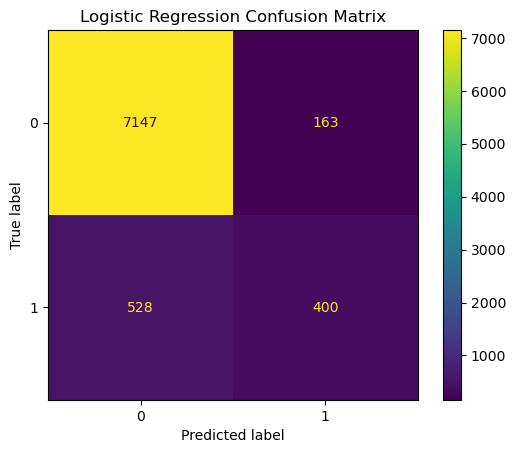

In [9]:
# Evaluate Logistic Regression
evaluate_model(logreg_pipeline, X_test, y_test, "Logistic Regression")

Random Forest Confusion Matrix:
[[7129  181]
 [ 488  440]]
Random Forest F1 Score: 0.5681
Random Forest ROC AUC: 0.9465


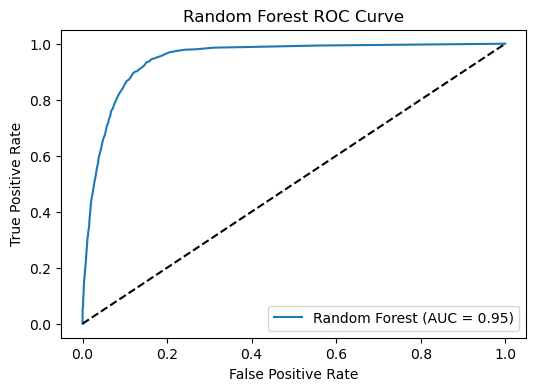

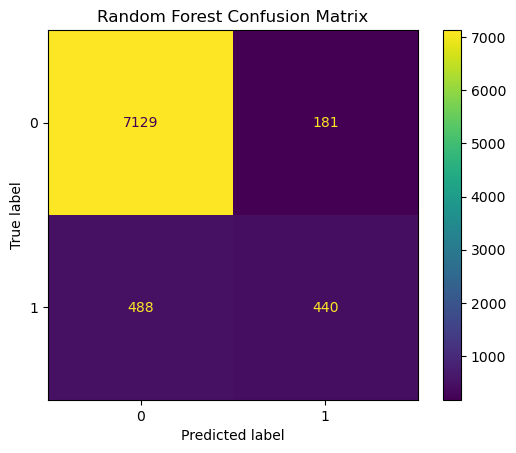

In [10]:
# Evaluate Random Forest
evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")

In [12]:
from lime.lime_tabular import LimeTabularExplainer
# --- Get encoded feature names from the preprocessor ---
ohe = rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
cat_names = list(ohe.get_feature_names_out(cat_cols))
num_cols = [c for c in X.columns if c not in cat_cols]
feature_names = cat_names + num_cols

# --- Transform train/test for LIME ---
X_train_enc = rf_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_enc  = rf_pipeline.named_steps["preprocessor"].transform(X_test)
# --- Initialize LIME explainer ---
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_enc),
    feature_names=feature_names,
    class_names=['No', 'Yes'],  # target: 0 = No, 1 = Yes
    mode='classification'
)




🔹 Random Forest LIME Explanations

Sample 3916 Explanation:
[('duration > 319.00', 0.23795413816832164), ('month_oct <= 0.00', -0.09034908874441376), ('month_mar <= 0.00', -0.05964225451022764), ('poutcome_success <= 0.00', -0.048062683940333153), ('marital_unknown <= 0.00', -0.027838076680329133), ('1.34 < euribor3m <= 4.86', -0.025699122179344027), ('5099.10 < nr.employed <= 5191.00', -0.02433212300909644), ('month_sep <= 0.00', -0.022190545589654664), ('job_unknown <= 0.00', -0.021700946233415026), ('education_illiterate <= 0.00', 0.005168400647304206)]


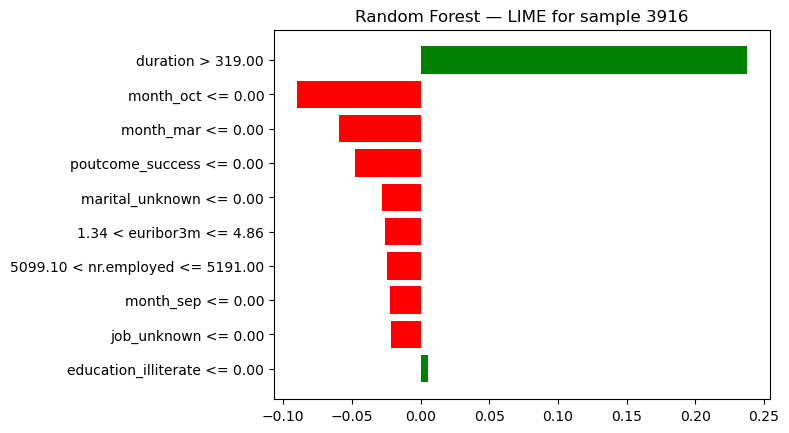


Sample 7361 Explanation:
[('duration <= 103.00', -0.13148660699315073), ('month_oct <= 0.00', -0.1051387533801191), ('month_mar <= 0.00', -0.08113371200208842), ('nr.employed <= 5099.10', 0.061006361532083934), ('emp.var.rate <= -1.80', 0.05792392776631674), ('euribor3m <= 1.34', 0.04608819052849326), ('poutcome_success <= 0.00', -0.04256459092229128), ('marital_unknown <= 0.00', -0.03255081020049755), ('education_illiterate <= 0.00', 0.028007418455930716), ('default_yes <= 0.00', -0.018410041159556783)]


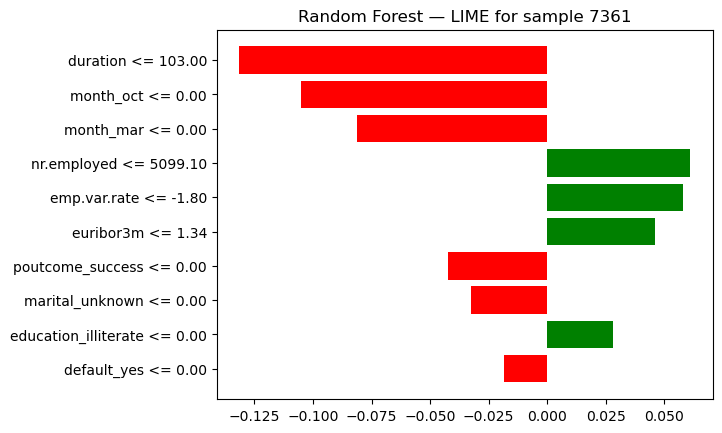


Sample 5447 Explanation:
[('duration <= 103.00', -0.13207897476254657), ('month_oct <= 0.00', -0.1116270647429655), ('month_mar <= 0.00', -0.06653769977186039), ('poutcome_success <= 0.00', -0.05784179308805749), ('education_illiterate <= 0.00', -0.03266516325938531), ('month_sep <= 0.00', -0.03022116110957706), ('5099.10 < nr.employed <= 5191.00', -0.023193770930239603), ('marital_unknown <= 0.00', -0.020895325524602656), ('job_unknown <= 0.00', -0.02002708826092298), ('1.34 < euribor3m <= 4.86', -0.019852846015919186)]


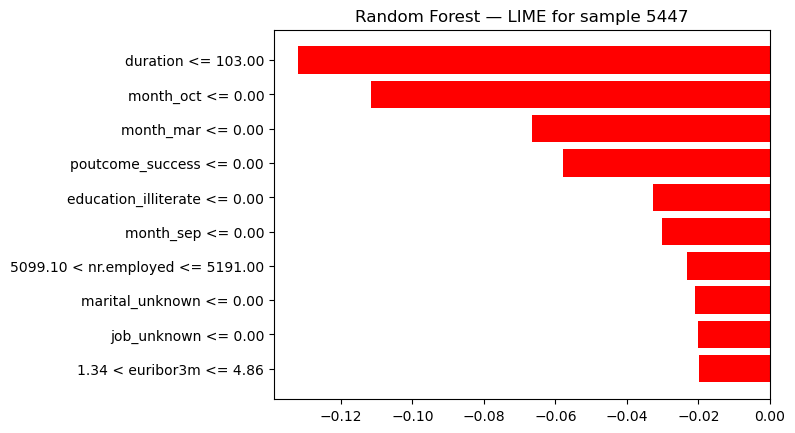


Sample 4615 Explanation:
[('duration <= 103.00', -0.13167950257714967), ('month_oct <= 0.00', -0.11645047280118594), ('month_mar <= 0.00', -0.05912415126059685), ('marital_unknown <= 0.00', -0.04642636428169869), ('5191.00 < nr.employed <= 5228.10', -0.044546278629169475), ('1.10 < emp.var.rate <= 1.40', -0.04152752833078768), ('default_yes <= 0.00', 0.0342334186971112), ('month_sep <= 0.00', -0.028611356622157056), ('poutcome_success <= 0.00', -0.026381280577369024), ('poutcome_failure <= 0.00', 0.021005193845520263)]


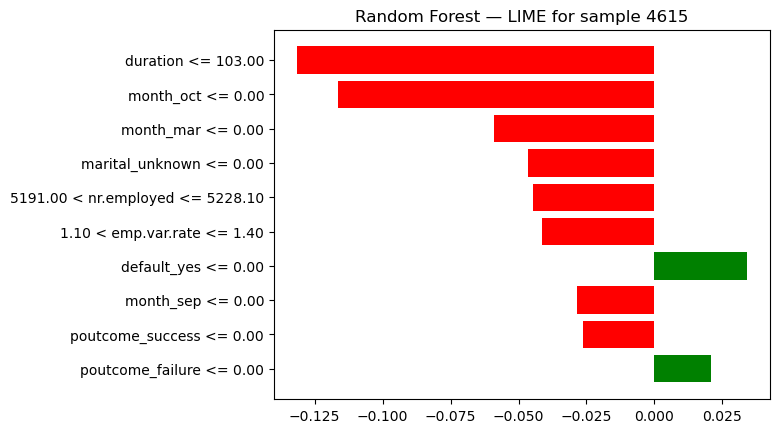


Sample 3361 Explanation:
[('duration > 319.00', 0.23296030693269737), ('month_oct <= 0.00', -0.11164016733742846), ('poutcome_success <= 0.00', -0.06705550283498019), ('month_mar <= 0.00', -0.05539546654460082), ('1.34 < euribor3m <= 4.86', -0.02418180361251845), ('5099.10 < nr.employed <= 5191.00', -0.02057726887984046), ('education_illiterate <= 0.00', 0.018305121948128313), ('93.75 < cons.price.idx <= 93.99', -0.015199144377512805), ('marital_unknown <= 0.00', -0.014187388355242473), ('job_unknown <= 0.00', 0.010422588438876276)]


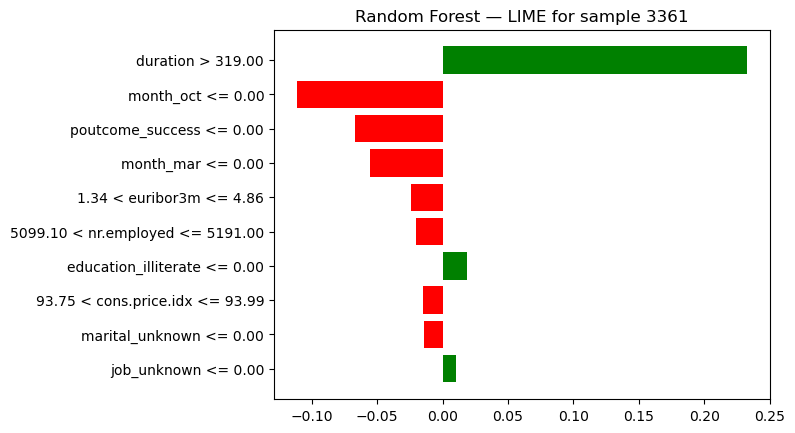

In [13]:
# ---------------------------
# Random Forest LIME
# ---------------------------
rf_model = rf_pipeline.named_steps["classifier"]

print("\n🔹 Random Forest LIME Explanations")
idxs = np.random.choice(X_test_enc.shape[0], 5, replace=False)  # 5 random samples
for i in idxs:
    exp = explainer.explain_instance(
        data_row=X_test_enc[i],
        predict_fn=rf_model.predict_proba,
        num_features=10
    )
    print(f"\nSample {i} Explanation:")
    print(exp.as_list())  # text output
    exp.as_pyplot_figure()
    plt.title(f"Random Forest — LIME for sample {i}")
    plt.show()



🔹 Logistic Regression LIME Explanations

Sample 3916 Explanation:
[('duration > 319.00', 0.31223314610386493), ('marital_unknown <= 0.00', 0.07978580894389846), ('0.00 < month_may <= 1.00', -0.06565274917999402), ('job_blue-collar <= 0.00', 0.027537898321234867), ('job_unknown <= 0.00', 0.027440512047829064), ('0.00 < contact_telephone <= 1.00', -0.02625108267287362), ('housing_unknown <= 0.00', -0.025759682582460253), ('month_sep <= 0.00', 0.024880704650456404), ('poutcome_failure <= 0.00', 0.022982500439704828), ('education_illiterate <= 0.00', 0.021416054564107112)]


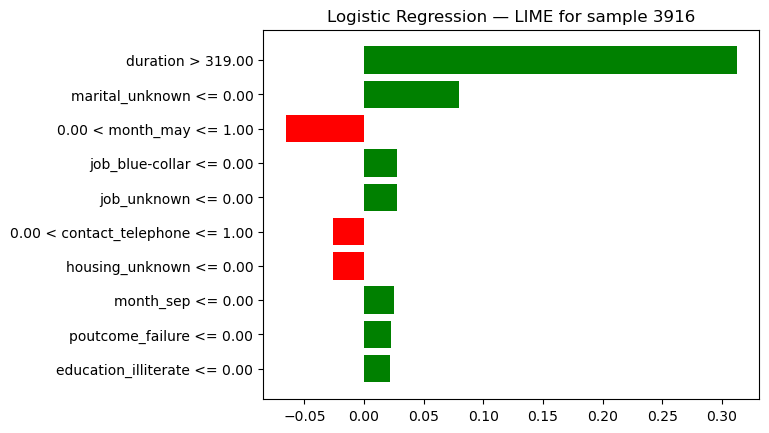


Sample 7361 Explanation:
[('duration <= 103.00', -0.12205735244270359), ('education_illiterate <= 0.00', -0.10959047333526588), ('nr.employed <= 5099.10', 0.08995307036957921), ('emp.var.rate <= -1.80', 0.074955911138054), ('0.00 < month_may <= 1.00', -0.06368896684546534), ('marital_unknown <= 0.00', 0.04809638264064527), ('default_unknown <= 0.00', 0.03011871650643502), ('housing_unknown <= 0.00', 0.029649815942549358), ('poutcome_failure <= 0.00', 0.02805133790985831), ('cons.price.idx <= 93.08', -0.02550700090465555)]


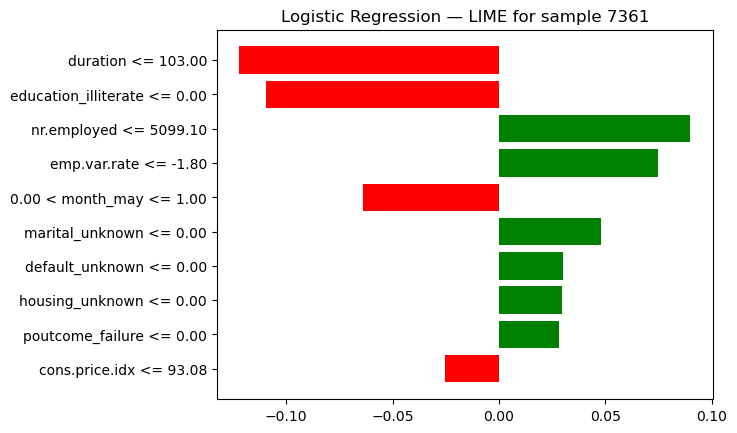


Sample 5447 Explanation:
[('duration <= 103.00', -0.1230880307826467), ('education_illiterate <= 0.00', 0.0798635013434367), ('0.00 < month_may <= 1.00', -0.06124680667880418), ('marital_unknown <= 0.00', 0.05313060610855084), ('month_jun <= 0.00', -0.029259525081123627), ('month_jul <= 0.00', -0.028806892467557136), ('job_unknown <= 0.00', -0.027820394630021464), ('job_retired <= 0.00', -0.02675857438767991), ('education_unknown <= 0.00', -0.024161584190995396), ('education_basic.9y <= 0.00', 0.02097835335125016)]


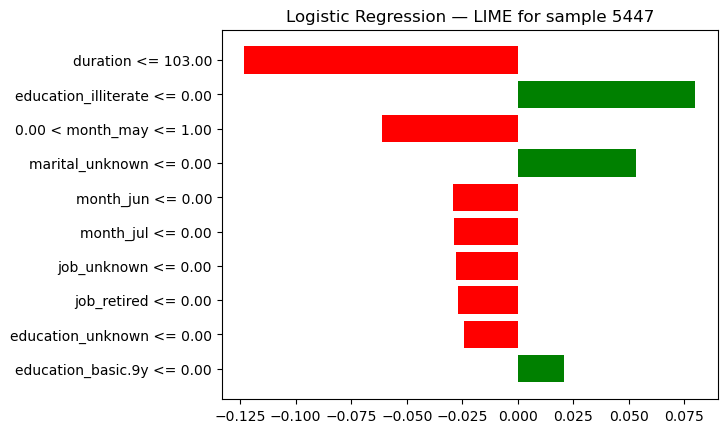


Sample 4615 Explanation:
[('duration <= 103.00', -0.1253825720972554), ('marital_unknown <= 0.00', 0.08518777088396717), ('month_dec <= 0.00', -0.07182570412398324), ('month_may <= 0.00', 0.06347068097185038), ('5191.00 < nr.employed <= 5228.10', -0.06291726284927358), ('1.10 < emp.var.rate <= 1.40', -0.05779277250824185), ('month_sep <= 0.00', 0.035862547950264015), ('month_mar <= 0.00', -0.031051983291165545), ('month_aug <= 0.00', -0.02928309996826619), ('month_jun <= 0.00', -0.02232244398984339)]


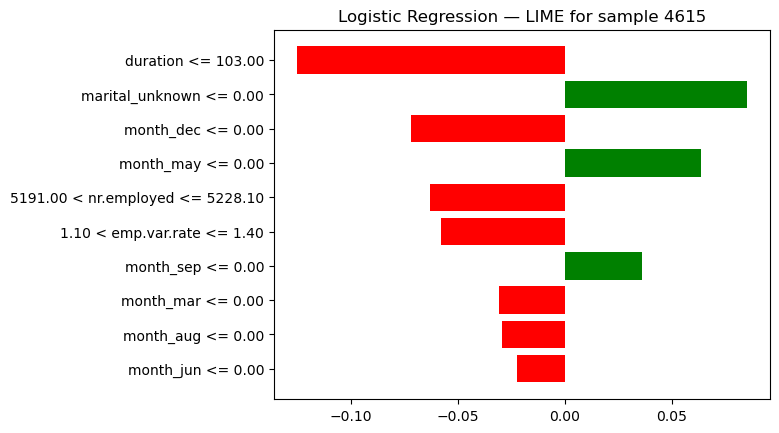


Sample 3361 Explanation:
[('duration > 319.00', 0.2897258019060663), ('0.00 < month_may <= 1.00', -0.06338888853099058), ('month_dec <= 0.00', 0.02963783097863816), ('education_unknown <= 0.00', -0.02627917005696454), ('93.75 < cons.price.idx <= 93.99', 0.026189807950994532), ('contact_cellular <= 0.00', -0.025079943309750278), ('poutcome_failure <= 0.00', 0.025041715860833532), ('previous <= 0.00', 0.02494715128068145), ('5099.10 < nr.employed <= 5191.00', -0.024262047714163303), ('0.00 < contact_telephone <= 1.00', -0.022136368127803775)]


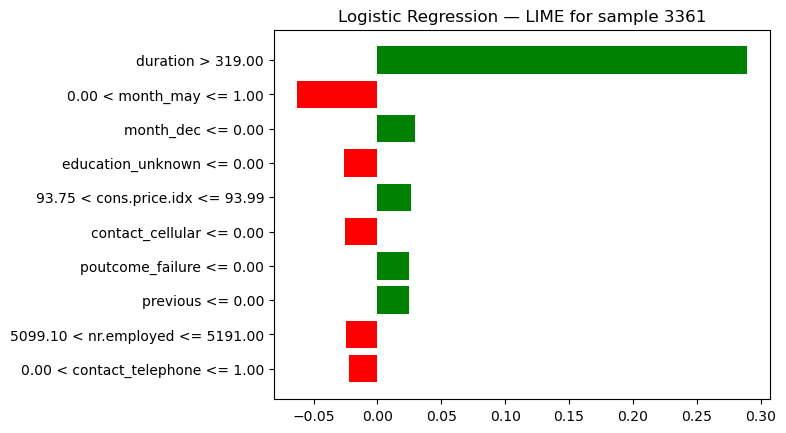

In [14]:
# ---------------------------
# Logistic Regression LIME
# ---------------------------
lr_model = logreg_pipeline.named_steps["classifier"]

print("\n🔹 Logistic Regression LIME Explanations")
for i in idxs:
    exp = explainer.explain_instance(
        data_row=X_test_enc[i],
        predict_fn=lr_model.predict_proba,
        num_features=10
    )
    print(f"\nSample {i} Explanation:")
    print(exp.as_list())
    exp.as_pyplot_figure()
    plt.title(f"Logistic Regression — LIME for sample {i}")
    plt.show()